## Average Price Forecasting

## ARIMA

Best orders: (0, 0, 3) (2, 1, 1, 12)

Hold‑out 2023 →  RMSE £10,988   MAE £9,327


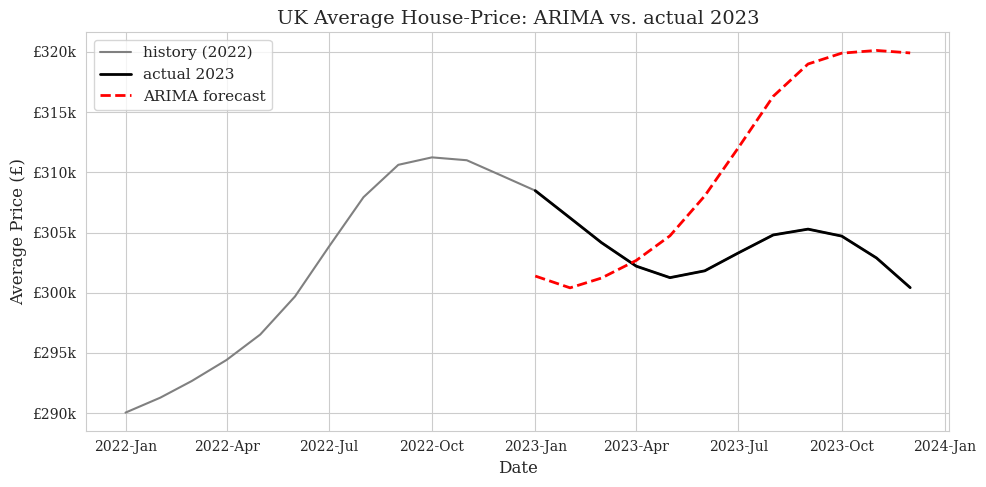

In [103]:
# --- Monthly price series -----------------------------------
ser = (df_processed                    
       .groupby("Date")["AveragePrice"]
       .mean()
       .asfreq("MS")
       .ffill())

train, test = ser[:-12], ser[-12:]

# --- Auto‑ARIMA order search --------------------------------
auto = pm.auto_arima(
    train,           # you can feed the raw series
    d=0, D=1, m=12,
    seasonal=True, stepwise=True,
    suppress_warnings=True,
    error_action="ignore"
)
print("Best orders:", auto.order, auto.seasonal_order)

# --- Fit best ARIMA -----------------------------------------
model = ARIMA(train, order=auto.order,
              seasonal_order=auto.seasonal_order).fit()

arima_pred  = pd.Series(model.forecast(12), index=test.index)

# --- Metrics -------------------------------------------------
rmse_arima = np.sqrt(mean_squared_error(test, arima_pred))
mae_arima  = mean_absolute_error(test, arima_pred)
print(f"Hold‑out 2023 →  RMSE £{rmse_arima:,.0f}   MAE £{mae_arima:,.0f}")

# --- Plot ----------------------------------------------------
plt.figure(figsize=(10,5))
plt.plot(ser["2022":], c="grey", lw=1.5, label="history (2022)")
plt.plot(test,         "k-",  lw=2, label="actual 2023")
plt.plot(arima_pred,         "r--", lw=2, label="ARIMA forecast")
plt.title("UK Average House‑Price: ARIMA vs. actual 2023")
plt.xlabel("Date"); plt.ylabel("Average Price (£)")
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y‑%b"))
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda v,_: f"£{v/1e3:,.0f}k"))
plt.legend(); plt.tight_layout(); plt.show()


## XGBOOST (TS LAG)

Fitting 5 folds for each of 30 candidates, totalling 150 fits

Best parameters: {'colsample_bytree': 0.836965827544817, 'gamma': 0.01858016508799909, 'learning_rate': 0.10113172778521574, 'max_depth': 7, 'n_estimators': 1040, 'subsample': 0.6260206371941118}
CV RMSE: 14704.289183008606

Hold‑out 2023 →  RMSE £3,831   MAE £3,420


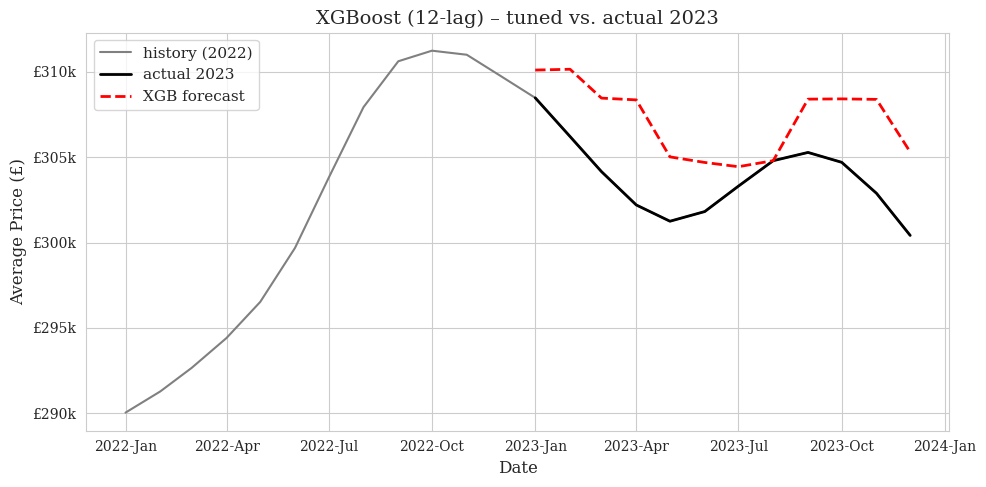

In [104]:
# ------------ monthly average series ------------------------
ser = (df_processed
       .groupby("Date")["AveragePrice"].mean()
       .asfreq("MS").ffill())

train, test = ser[:-12], ser[-12:]

# ------------ create 12‑lag feature matrix ------------------
lag_df = pd.DataFrame({"y": ser})
for l in range(1,13):
    lag_df[f"lag{l}"] = lag_df["y"].shift(l)
lag_df["month"] = lag_df.index.month
lag_df.dropna(inplace=True)

X, y = lag_df.drop("y", axis=1), lag_df["y"]
X_train, X_test = X.loc[train.index.intersection(X.index)], X.loc[test.index]

sc = MinMaxScaler()
X_train_s = sc.fit_transform(X_train)
X_test_s  = sc.transform(X_test)

# ------------ hyper‑parameter search ------------------------
tscv   = TimeSeriesSplit(n_splits=5)
score  = make_scorer(lambda yt, yp: -np.sqrt(mean_squared_error(yt, yp)))

param_grid = {
    "n_estimators": randint(200, 1200),
    "learning_rate": uniform(0.01, 0.15),
    "max_depth": randint(3, 8),
    "subsample": uniform(0.6, 0.4),
    "colsample_bytree": uniform(0.6, 0.4),
    "gamma": uniform(0, 0.4)
}

rs = RandomizedSearchCV(
        xgb.XGBRegressor(objective="reg:squarederror", random_state=42),
        param_distributions = param_grid,
        n_iter = 30, cv = tscv, scoring = score,
        n_jobs = -1, random_state = 42, verbose = 1)
rs.fit(X_train_s, y_train := y.loc[X_train.index])

print("Best parameters:", rs.best_params_)
print("CV RMSE:", -rs.best_score_)

# ------------ refit best model on full train ---------------
best_xgb = rs.best_estimator_
best_xgb.fit(X_train_s, y_train)

xgb_ts_pred = pd.Series(best_xgb.predict(X_test_s), index=test.index)
rmse_xg_t = np.sqrt(mean_squared_error(test, xgb_ts_pred))
mae_xg_t  = mean_absolute_error(test, xgb_ts_pred)
print(f"\nHold‑out 2023 →  RMSE £{rmse_xg_t:,.0f}   MAE £{mae_xg_t:,.0f}")

# ------------ plot -----------------------------------------
plt.figure(figsize=(10,5))
plt.plot(ser["2022":],        c="grey", lw=1.5, label="history (2022)")
plt.plot(test,                "k-",   lw=2,   label="actual 2023")
plt.plot(xgb_ts_pred,                "r--",  lw=2,   label="XGB forecast")
plt.title("XGBoost (12‑lag) – tuned vs. actual 2023")
plt.xlabel("Date"); plt.ylabel("Average Price (£)")
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y‑%b"))
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda v,_: f"£{v/1e3:,.0f}k"))
plt.legend(); plt.tight_layout(); plt.show()


## XGBOOST (Hedonic)

Best params: {'colsample_bytree': 0.6557325817623503, 'gamma': 0.24176695171112692, 'learning_rate': 0.09097616369525097, 'max_depth': 7, 'n_estimators': 335, 'subsample': 0.9771414282231924}   CV RMSE: 14387.453872326141

Hold‑out 2023 →  RMSE £1,258   MAE £1,099


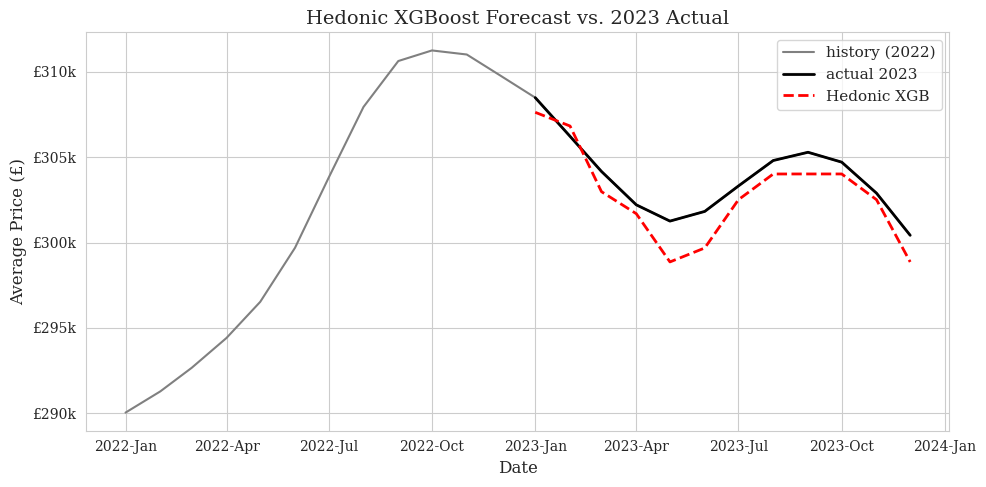

In [105]:
# ---  Monthly hedonic panel ---------------------------------
pcols = ["AveragePrice","DetachedPrice","SemiDetachedPrice",
         "TerracedPrice","FlatPrice"]

panel = (df_processed
         .groupby("Date")[pcols].mean()
         .asfreq("MS").ffill())            # 2010‑01 … 2023‑12, no gaps

# national average for plotting + split index
avg_ser   = panel["AveragePrice"]
train_idx = avg_ser.index[:-12]            # Jan‑2010 … Dec‑2022
test_idx  = avg_ser.index[-12:]            # Jan‑2023 … Dec‑2023

# ---  Build lag‑matrix (12 lags * 5 series) -----------------
def add_lags(df, n=12):
    out = df.copy()
    for col in df.columns:
        for l in range(1, n+1):
            out[f"{col}_lag{l}"] = df[col].shift(l)
    out["month"] = out.index.month
    return out.dropna()

lag_df   = add_lags(panel, 12)
X, y     = lag_df.drop("AveragePrice", axis=1), lag_df["AveragePrice"]
X_train  = X.loc[train_idx.intersection(X.index)]
y_train  = y.loc[X_train.index]
X_test   = X.loc[test_idx]

sc       = MinMaxScaler()
X_tr_s   = sc.fit_transform(X_train)
X_te_s   = sc.transform(X_test)

# ---  Hyper‑parameter search --------------------------------
tscv   = TimeSeriesSplit(n_splits=5)
score  = make_scorer(lambda yt, yp: -np.sqrt(mean_squared_error(yt, yp)))

param_grid = {
    "n_estimators"     : randint(300,1200),
    "learning_rate"    : uniform(0.01,0.15),
    "max_depth"        : randint(3,8),
    "subsample"        : uniform(0.6,0.4),
    "colsample_bytree" : uniform(0.6,0.4),
    "gamma"            : uniform(0,0.4)
}

rs = RandomizedSearchCV(
        xgb.XGBRegressor(objective="reg:squarederror", random_state=42),
        param_distributions = param_grid,
        n_iter = 25, cv = tscv, scoring = score,
        n_jobs = -1, random_state = 42, verbose = 0)
rs.fit(X_tr_s, y_train)

print("Best params:", rs.best_params_, 
      "  CV RMSE:", -rs.best_score_)

best_xgb = rs.best_estimator_
best_xgb.fit(X_tr_s, y_train)

# ---  Predict + metrics -------------------------------------
h_pred  = pd.Series(best_xgb.predict(X_te_s), index=test_idx)
rmse_xg_h  = np.sqrt(mean_squared_error(avg_ser[test_idx], h_pred))
mae_xg_h   = mean_absolute_error(avg_ser[test_idx], h_pred)
print(f"Hold‑out 2023 →  RMSE £{rmse_xg_h:,.0f}   MAE £{mae_xg_h:,.0f}")

# ---   Plot ---------------------------------------------------
plt.figure(figsize=(10,5))
plt.plot(avg_ser["2022":],       c="grey", lw=1.5, label="history (2022)")
plt.plot(avg_ser[test_idx],      "k-",   lw=2,   label="actual 2023")
plt.plot(h_pred,                   "r--",  lw=2,   label="Hedonic XGB")
plt.title("Hedonic XGBoost Forecast vs. 2023 Actual")
plt.xlabel("Date"); plt.ylabel("Average Price (£)")
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y‑%b"))
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda v,_: f"£{v/1e3:,.0f}k"))
plt.legend(); plt.tight_layout(); plt.show()


## Random Forest (Hedonic)

Best params: {'max_depth': 8, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 414}   CV RMSE: 15507.876659138943

Hold‑out 2023 →  RMSE £4,990   MAE £4,618


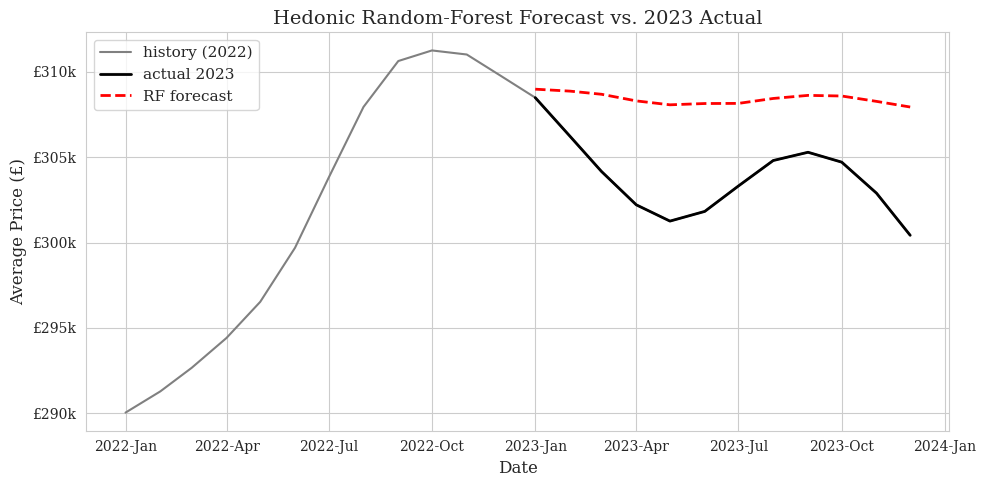

In [106]:
# ---------- monthly hedonic panel --------------------------
pcols  = ["AveragePrice","DetachedPrice","SemiDetachedPrice",
          "TerracedPrice","FlatPrice"]

panel = (df_processed
         .groupby("Date")[pcols].mean()
         .asfreq("MS").ffill())              # 2010‑01 … 2023‑12

avg_ser   = panel["AveragePrice"]
train_idx = avg_ser.index[:-12]              # up to 2022‑12
test_idx  = avg_ser.index[-12:]              # 2023 months

# ---------- add 12 lags to each series ---------------------
def lagify(df, n=12):
    out = df.copy()
    for c in df.columns:
        for l in range(1, n+1):
            out[f"{c}_lag{l}"] = df[c].shift(l)
    out["month"] = out.index.month
    return out.dropna()

lags   = lagify(panel, 12)
X, y   = lags.drop("AveragePrice", axis=1), lags["AveragePrice"]
X_tr   = X.loc[train_idx.intersection(X.index)]
y_tr   = y.loc[X_tr.index]
X_te   = X.loc[test_idx]

# scale
sc     = MinMaxScaler()
X_tr_s = sc.fit_transform(X_tr)
X_te_s = sc.transform(X_te)

# ---------- hyper‑parameter search --------------------------
tscv  = TimeSeriesSplit(5)
score = make_scorer(lambda yt, yp: -np.sqrt(mean_squared_error(yt, yp)))

grid  = {"n_estimators": randint(200,1000),
         "max_depth"  : [None] + list(range(5,16)),
         "min_samples_split": randint(2,10),
         "min_samples_leaf" : randint(1,6),
         "max_features": ["sqrt","log2",None]}

rs = RandomizedSearchCV(
        RandomForestRegressor(random_state=42, n_jobs=-1),
        param_distributions = grid,
        n_iter = 25, cv = tscv, scoring = score,
        n_jobs = -1, random_state = 42, verbose = 0)
rs.fit(X_tr_s, y_tr)

print("Best params:", rs.best_params_,
      "  CV RMSE:", -rs.best_score_)

rf = rs.best_estimator_
rf.fit(X_tr_s, y_tr)

# ---------- predict + metrics -------------------------------
rf_pred  = pd.Series(rf.predict(X_te_s), index=test_idx)
rmse_rf  = np.sqrt(mean_squared_error(avg_ser[test_idx], rf_pred))
mae_rf  = mean_absolute_error(avg_ser[test_idx], rf_pred)
print(f"\nHold‑out 2023 →  RMSE £{rmse_rf:,.0f}   MAE £{mae_rf:,.0f}")

# ---------- plot -------------------------------------------
plt.figure(figsize=(10,5))
plt.plot(avg_ser["2022":],        c="grey", lw=1.5, label="history (2022)")
plt.plot(avg_ser[test_idx],       "k-",   lw=2,   label="actual 2023")
plt.plot(rf_pred,                    "r--",  lw=2,   label="RF forecast")
plt.title("Hedonic Random‑Forest Forecast vs. 2023 Actual")
plt.xlabel("Date"); plt.ylabel("Average Price (£)")
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y‑%b"))
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda v,_: f"£{v/1e3:,.0f}k"))
plt.legend(); plt.tight_layout(); plt.show()

## SVR (Hedonic)

Best SVR params: {'C': 291.5443189153751, 'epsilon': 0.13022300234864176, 'gamma': 0.06796578090758151, 'kernel': 'linear'}
2023 Hold‑out → RMSE £5,951   MAE £5,557


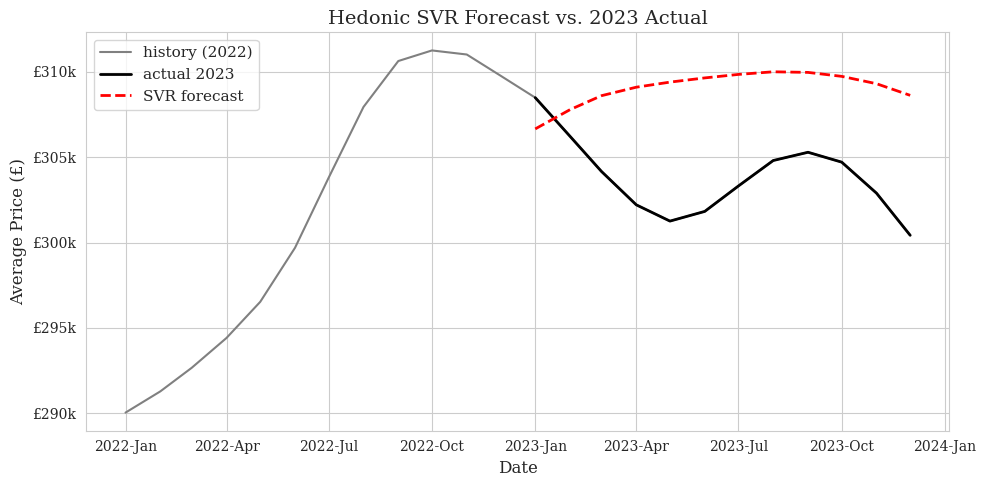

In [107]:

# --- build monthly hedonic panel ----------------------------
props = ["AveragePrice","DetachedPrice","SemiDetachedPrice",
         "TerracedPrice","FlatPrice"]
panel = (df_processed
         .groupby("Date")[props].mean()
         .asfreq("MS")
         .ffill())

# national average for splitting and plotting
avg = panel["AveragePrice"]
train_idx, test_idx = avg.index[:-12], avg.index[-12:]
train_ser, test_ser = avg.loc[train_idx], avg.loc[test_idx]

# --- create lag features + month dummy -----------------------
def make_lags(df, n=12):
    out = df.copy()
    for c in df.columns:
        for lag in range(1, n+1):
            out[f"{c}_lag{lag}"] = df[c].shift(lag)
    out["month"] = out.index.month
    return out.dropna()

lags = make_lags(panel, 12)
X, y = lags.drop("AveragePrice", axis=1), lags["AveragePrice"]
X_tr = X.loc[train_idx.intersection(X.index)]
y_tr = y.loc[X_tr.index]
X_te = X.loc[test_idx]

# --- scale features ------------------------------------------
sc = MinMaxScaler()
X_tr_s = sc.fit_transform(X_tr)
X_te_s = sc.transform(X_te)

# --- hyper‑parameter search ----------------------------------
tscv = TimeSeriesSplit(n_splits=5)
scorer = make_scorer(lambda yt, yp: -np.sqrt(mean_squared_error(yt, yp)))

param_dist = {
    "kernel": ['rbf','linear'],
    "C":       loguniform(1e-1, 1e3),
    "gamma":   loguniform(1e-4, 1e0),
    "epsilon": uniform(0.01, 0.2)
}

rs = RandomizedSearchCV(
    SVR(), param_distributions=param_dist,
    n_iter=25, cv=tscv, scoring=scorer,
    n_jobs=-1, random_state=42, verbose=0
)
rs.fit(X_tr_s, y_tr)
print("Best SVR params:", rs.best_params_)

# --- fit best SVR & predict ---------------------------------
svr = rs.best_estimator_
svr.fit(X_tr_s, y_tr)
svr_pred = pd.Series(svr.predict(X_te_s), index=test_idx)

# --- compute metrics ----------------------------------------
rmse_svr = np.sqrt(mean_squared_error(test_ser, svr_pred))
mae_svr  = mean_absolute_error(test_ser, svr_pred)
print(f"2023 Hold‑out → RMSE £{rmse_svr:,.0f}   MAE £{mae_svr:,.0f}")

# --- plot results -------------------------------------------
plt.figure(figsize=(10,5))
plt.plot(avg["2022":],      c="grey", lw=1.5, label="history (2022)")
plt.plot(test_ser,          "k-",   lw=2,   label="actual 2023")
plt.plot(svr_pred,              "r--",  lw=2,   label="SVR forecast")
plt.title("Hedonic SVR Forecast vs. 2023 Actual")
plt.xlabel("Date"); plt.ylabel("Average Price (£)")
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y‑%b"))
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda v,_: f"£{v/1e3:,.0f}k"))
plt.legend(); plt.tight_layout(); plt.show()